In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import selenium 
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
import plotly.offline as py


py.init_notebook_mode(connected=True)

%matplotlib inline

ModuleNotFoundError: No module named 'selenium'

In [ ]:
browser = webdriver.Chrome()
url = 'https://www.canadiantire.ca/en/automotive/tires-wheels/tires.html?adlocation=LOL_TiresSCLP_MegaNavAuto_19309_en;page=1'
browser.get(url) 
time.sleep(10)


The canadian tire website uses dynamically generated content for its html through javascript. We need to import selenium and use a webdriver to load all of the content before we can scrape and parse it. Another thing to keep in mind is the fact that the site takes some time to load all of this information. That is why I set the sleep to 10 seconds. This gives us more than enough time to load everything needed.

In [2]:
loadMoreButton = True

while True:
    try:
        loadMoreButton = browser.find_element_by_class_name('srp-grid__load-more-link')
        time.sleep(3)
        loadMoreButton.click()
        time.sleep(1)
    except:
        print('no more load buttons to click')
        loadMoreButton = False
        break

no more load buttons to click


In [3]:
html = browser.page_source 
soup = BeautifulSoup(html, 'lxml')
result = soup.find(class_='srp-grid__content')
items = result.find_all(class_ = 'automotive-product-tile-srp__info')



NameError: name 'browser' is not defined

Fill in the none type rows with a nice median price of 200 dollars in the price list

In [4]:
price_list = []
new_price_list = []

for price in items:
        price_list.append(price.find(class_='automotive-price__current-price'))
        
for price in price_list:
    if price is None:
        new_price_list.append('$200')
    else:
        new_price_list.append(price.get_text(strip=True))


newest_series = []
for price in new_price_list:
    newest_series.append(re.findall(r'\d+', price)[0])
    last_series = [float(i) for i in newest_series]
  



NameError: name 'items' is not defined

In [13]:
item_names = [name.find(class_='automotive-product-tile-srp__title').get_text(strip=True) for name in items]

In [14]:
rating_list = []

for rating in items:
    rating_list.append(float(rating.find(class_='bv-off-screen').get_text(strip=True).split()[0]))
    


In [15]:
category_list = []
new_category_list = []

for category in items:
    category_list.append(category.find(class_='automotive-product-tile-srp__category'))
for category in category_list:
    if category is None:
        new_category_list.append('no type')
    else:
        new_category_list.append(category.get_text(strip=True))


In [16]:
real_tire_names = []

for name in item_names:
    real_tire_names.append(re.findall(r'^\w+', name))



In [24]:
tire_df = pd.DataFrame({'tire name':real_tire_names,'weather type list':new_category_list,'ratings out of 5 stars': rating_list,'price list in CAD $': last_series})
tire_df.sort_values('price list in CAD $').head(5)


,tire name,weather type list,ratings out of 5 stars,price list in CAD $
228,[MotoMaster],Highway Tires,3.6,34.0
24,[Hankook],Winter Tires,4.4,44.0
13,[MotoMaster],All Season Tires,4.2,44.0
3,[Certified],Winter Tires,5.0,46.0
198,[Pirelli],Passenger Tires,4.8,52.0


In [159]:
tire_df.shape

(558, 4)

In [60]:
top_10 = tire_df['tire name'].value_counts().head(10)
print(top_10)

[Goodyear]       72
[Dunlop]         59
[Pirelli]        56
[Continental]    56
[Michelin]       51
[Bridgestone]    44
[Hankook]        34
[Cooper]         24
[Firestone]      24
[Yokohama]       24
Name: tire name, dtype: int64


In [135]:
rated_tires = tire_df[tire_df['ratings out of 5 stars'] >= 1]
rated_tires.set_index('tire name', inplace=True)
rated_tires

,weather type list,ratings out of 5 stars,price list in CAD $
tire name,,,
[Continental],All Season Tires,4.4,98.0
[Michelin],Winter Tires,4.7,86.0
[Certified],Winter Tires,5.0,46.0
[Goodyear],All Terrain Tires,4.3,242.0
[Michelin],Winter Tires,4.7,125.0
...,...,...,...
[Pirelli],Winter Tires,4.0,152.0
[Dunlop],All Season Tires,3.5,320.0
[Goodyear],Passenger Tires,4.0,388.0


In [148]:
five_star_only = rated_tires[rated_tires['ratings out of 5 stars'] == 5]
five_star_plot_data = five_star_only['price list in CAD $']
top_20_plot_data = five_star_plot_data.sort_values().head(20)

BELOW WE SEE A CHART INDICATING THAT THE HIGHEST RATED ALSO TYPICALLY WERE THE LEAST EXPENSIVE

Text(0.5, 1.0, 'top 20 best priced tires with 5 star reviews')

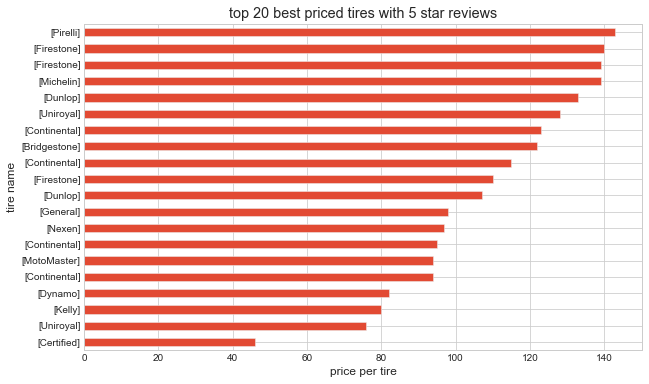

In [152]:
top_20_plot_data.plot.barh()
plt.xlabel('price per tire')
plt.ylabel('tire name')
plt.title('top 20 best priced tires with 5 star reviews')

Text(0.5, 1.0, 'Ratings and prices')

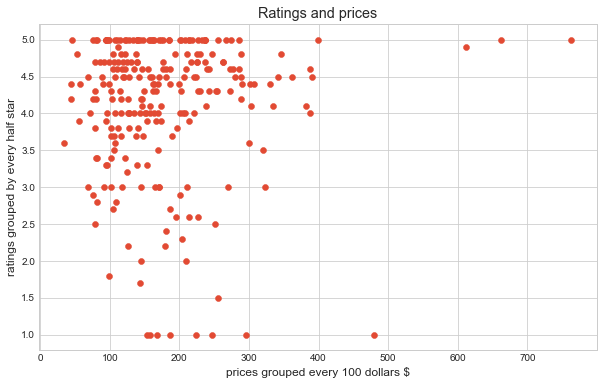

In [160]:
plt.style.use('seaborn-whitegrid')
plt.scatter(rated_tires['price list in CAD $'], rated_tires['ratings out of 5 stars'], label = 'ratings versus price')
plt.xlabel('prices grouped every 100 dollars $')
plt.ylabel('ratings grouped by every half star')
plt.title('Ratings and prices')



TOP 10 MOST COMMONLY SEEN BRAND STOCKED IN CANADIAN TIRE

Text(0.5, 1.0, 'Variety of tires per brand')

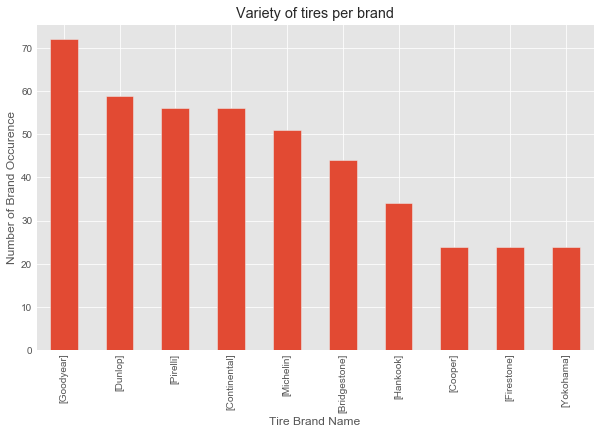

In [155]:
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('ggplot')
top_10.plot.bar()
plt.xlabel('Tire Brand Name')
plt.ylabel('Number of Brand Occurence')
plt.title('Variety of tires per brand')